In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os

# Read the data
train_data = pd.read_csv("./train_data.csv")
valid_data = pd.read_csv("./validation_data.csv")

# Preprocess training data
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit="s")
agg_train_data = (
    train_data.groupby(["timestamp", "lat", "lon", "point"])
    .size()
    .reset_index(name="num_publications")
)
agg_train_data["hour"] = agg_train_data["timestamp"].dt.hour
agg_train_data["day_of_week"] = agg_train_data["timestamp"].dt.dayofweek
agg_train_data["day"] = agg_train_data["timestamp"].dt.day
agg_train_data["month"] = agg_train_data["timestamp"].dt.month
agg_train_data.sort_values(by=["point", "timestamp"], inplace=True)
agg_train_data["lag_1"] = agg_train_data.groupby("point")["num_publications"].shift(1)
X_train = agg_train_data.drop(columns=["num_publications", "timestamp", "point"])
y_train = agg_train_data["num_publications"]
mask = X_train["lag_1"].notna()
X_train = X_train[mask]
y_train = y_train[mask]

# Preprocess validation data
valid_data["hour"] = pd.to_datetime(valid_data["hour"], unit="s").dt.hour

# Add the missing columns
valid_data["timestamp"] = pd.to_datetime(valid_data["hour"], unit="s")
valid_data["date"] = pd.to_datetime(valid_data["timestamp"], unit="s")
valid_data["day_of_week"] = valid_data["timestamp"].dt.dayofweek
valid_data["day"] = valid_data["timestamp"].dt.day
valid_data["month"] = valid_data["timestamp"].dt.month
valid_data["lag_1"] = valid_data["sum"].shift(
    1
)  # Assuming 'sum' is analogous to 'num_publications' in training data

# Ensure the order of columns matches X_train
X_valid = valid_data[X_train.columns]
y_valid = valid_data["sum"]

mask_valid = X_valid["lag_1"].notna()
X_valid = X_valid[mask_valid]
y_valid = y_valid[mask_valid]

nan_rows = X_valid[X_valid.isnull().any(axis=1)]
# print(nan_rows)


# Convert data to tensors and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = (
    torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
)

X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(device)
y_valid_tensor = (
    torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1).to(device)
)

assert not X_valid_tensor.isnan().any(), "NaN values found in validation inputs!"
assert not y_valid_tensor.isnan().any(), "NaN values found in validation targets!"

# DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)


# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Add a sequence length dimension
        x = x.unsqueeze(1)
        # Only two dimensions for h0: [num_layers * num_directions, batch_size, hidden_size]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, hn = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_dim = X_train.shape[1]
hidden_dim = 64
num_layers = 2
output_dim = 1

model = GRUModel(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
# Training loop with tqdm progress bar
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for batch_idx, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)

        # Calculate the number of correct predictions
        predicted = torch.round(outputs)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)

        loss = criterion(outputs, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update tqdm progress bar
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    print(
        f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%"
    )

    # Validate on the validation dataset and compute the average mistake
    with torch.no_grad():
        model.eval()
        predictions = model(X_valid_tensor)
        average_mistake = (
            torch.abs((predictions - y_valid_tensor) / (predictions)).mean().item()
        )
        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Average Mistake on Validation Data: {average_mistake:.4f}"
        )
        # Plotting the predictions against the true values
        predictions_np = predictions.cpu().numpy().flatten()
        y_valid_np = y_valid.to_numpy()

        # Scatter plot the predictions against the true values
        predictions_np = predictions.cpu().numpy().flatten()
        y_valid_np = y_valid.to_numpy()

        plt.figure(figsize=(15, 7))

        plt.scatter(
            valid_data["hour"][mask_valid],
            predictions_np,
            label="Predictions",
            color="red",
            marker="o",
            s=5,
        )
        plt.scatter(
            valid_data["hour"][mask_valid],
            y_valid_np,
            label="True Values",
            color="blue",
            alpha=0.5,
            marker=".",
            s=5,
        )

        plt.xlabel("Time")
        plt.ylabel("Publications")
        plt.title("GRU Model Predictions vs True Values")
        plt.legend()
        plt.grid(True)
        plt.close()


# Save model weights
torch.save(model.state_dict(), "./gru_model_weights.pth")


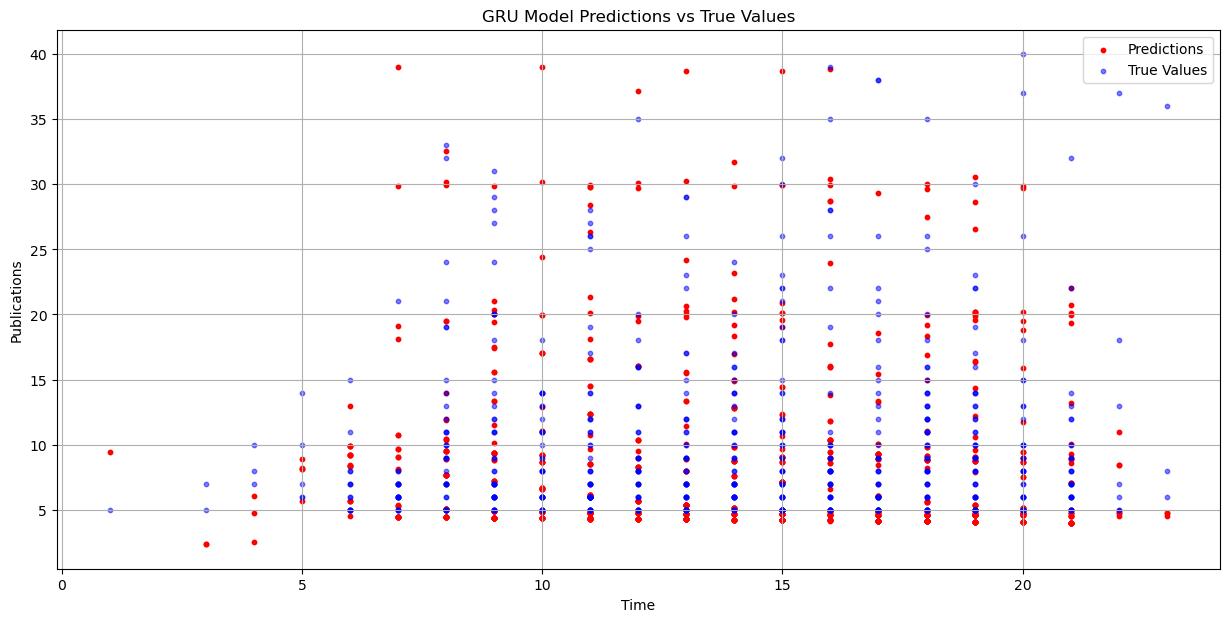

In [21]:
        plt.figure(figsize=(15, 7))

        plt.scatter(
            valid_data["hour"][mask_valid],
            predictions_np,
            label="Predictions",
            color="red",
            marker="o",
            s=10,
        )
        plt.scatter(
            valid_data["hour"][mask_valid],
            y_valid_np,
            label="True Values",
            color="blue",
            alpha=0.5,
            marker="o",
            s=10,
        )

        plt.xlabel("Time")
        plt.ylabel("Publications")
        plt.title("GRU Model Predictions vs True Values")
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.close()

In [23]:
f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Average Mistake on Validation Data: {average_mistake:.4f}"

'Epoch 1/1, Loss: 4.8477, Average Mistake on Validation Data: 0.8840'